# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.12KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

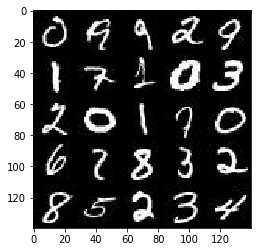

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

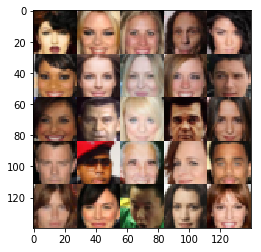

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    
    input_real, input_z, _ = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    n_images_to_display = 9
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images *= 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps%print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps%show_every == 0:
                    show_generator_output(sess, n_images_to_display, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 0.3235... Generator Loss: 1.6585
Epoch 1/2... Discriminator Loss: 0.3863... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 8.9418... Generator Loss: 0.0002
Epoch 1/2... Discriminator Loss: 1.7287... Generator Loss: 6.6575
Epoch 1/2... Discriminator Loss: 1.8547... Generator Loss: 0.2764
Epoch 1/2... Discriminator Loss: 3.8897... Generator Loss: 0.0329
Epoch 1/2... Discriminator Loss: 3.3881... Generator Loss: 0.0876
Epoch 1/2... Discriminator Loss: 2.3462... Generator Loss: 0.1882
Epoch 1/2... Discriminator Loss: 2.4263... Generator Loss: 5.9630


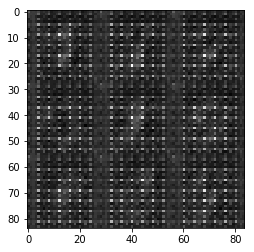

Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 0.3718... Generator Loss: 3.1301
Epoch 1/2... Discriminator Loss: 0.5596... Generator Loss: 1.4364
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 2.2371
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.3496
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.4122
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 0.3571... Generator Loss: 1.8409
Epoch 1/2... Discriminator Loss: 0.5198... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 1.7154


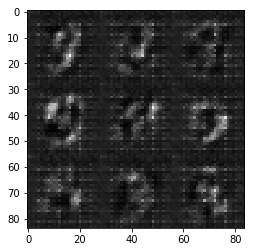

Epoch 1/2... Discriminator Loss: 0.4712... Generator Loss: 4.1216
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 1.9790
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 5.8381
Epoch 1/2... Discriminator Loss: 0.4241... Generator Loss: 1.8345
Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 1.8094
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 1.0560
Epoch 1/2... Discriminator Loss: 0.3247... Generator Loss: 2.1877
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 0.3295... Generator Loss: 1.6694
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.3494


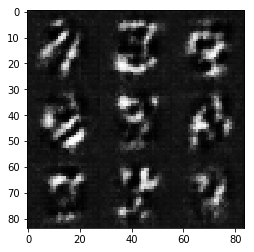

Epoch 1/2... Discriminator Loss: 1.5875... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 2.3139
Epoch 1/2... Discriminator Loss: 0.3584... Generator Loss: 1.5424
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 1.4341
Epoch 1/2... Discriminator Loss: 0.2259... Generator Loss: 3.2036
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 2.6283
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 0.3854... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 2.5469... Generator Loss: 7.9966


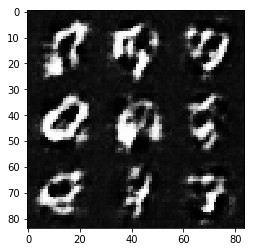

Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 2.0641
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 0.4952... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 0.4960... Generator Loss: 2.7946
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 2.1029
Epoch 1/2... Discriminator Loss: 0.5116... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 5.4596
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 4.6971
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.5297


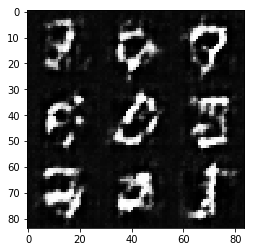

Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 1.6344
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 3.4995
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 2.3622
Epoch 1/2... Discriminator Loss: 1.8033... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 1.3193


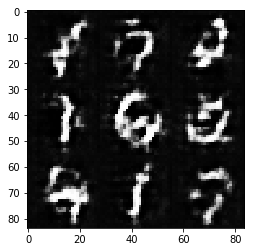

Epoch 1/2... Discriminator Loss: 0.5146... Generator Loss: 1.8583
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 2.3319
Epoch 1/2... Discriminator Loss: 0.6285... Generator Loss: 1.0541
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.8664
Epoch 1/2... Discriminator Loss: 0.8256... Generator Loss: 2.8526
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.5121
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.4620
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 0.6784... Generator Loss: 0.9465


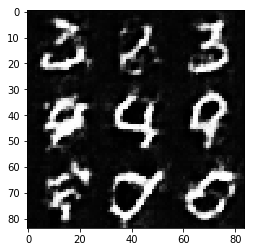

Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 0.9941
Epoch 1/2... Discriminator Loss: 1.9499... Generator Loss: 0.2293
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 2.0217
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 3.2672
Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 2.0266
Epoch 1/2... Discriminator Loss: 1.8465... Generator Loss: 0.2058
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 1.7879


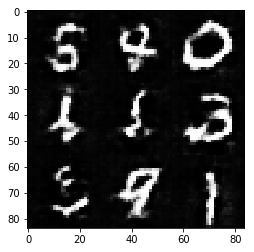

Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 3.0944
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 1.5606
Epoch 1/2... Discriminator Loss: 1.8787... Generator Loss: 0.2223
Epoch 1/2... Discriminator Loss: 1.8458... Generator Loss: 4.0499
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.5233
Epoch 1/2... Discriminator Loss: 2.1657... Generator Loss: 0.1691
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.5329


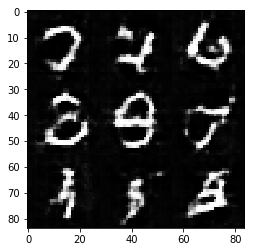

Epoch 1/2... Discriminator Loss: 0.5618... Generator Loss: 1.4677
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.8345
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.5738
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.4415
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.2845
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 1.9599
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 0.9956


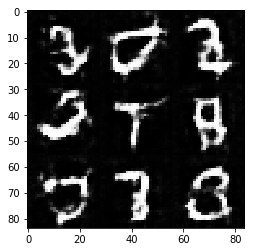

Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.4383
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.1421
Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 2.1214
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.5879
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 1.0691


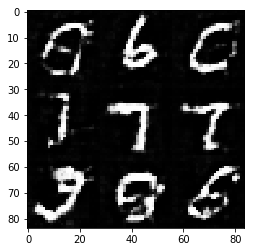

Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.2179
Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.3730
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 1.3583
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 2.8655... Generator Loss: 5.5345
Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.0441


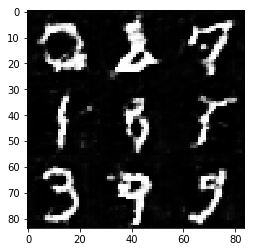

Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 2.2703
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.4783
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.4350
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 1.0288
Epoch 2/2... Discriminator Loss: 1.6276... Generator Loss: 0.2782
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.4165
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 4.1428
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.7984


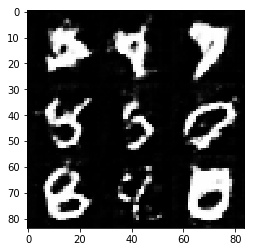

Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.2060
Epoch 2/2... Discriminator Loss: 1.8617... Generator Loss: 0.2022
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 0.7182
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 0.5968
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 2.5965
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 2.1517


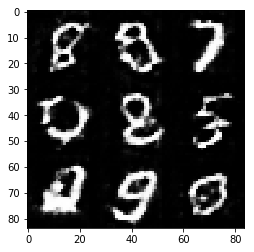

Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 0.6912... Generator Loss: 1.3058
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.3670
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.6968
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 1.4376
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.5138


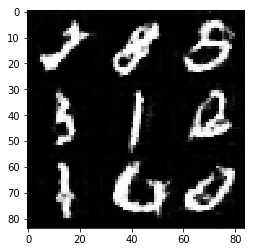

Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.4950
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 1.8305
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.4323
Epoch 2/2... Discriminator Loss: 1.4732... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.5869
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 0.8138


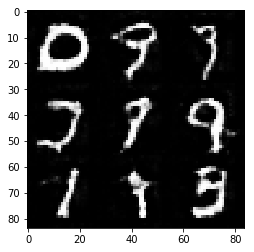

Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.6406
Epoch 2/2... Discriminator Loss: 0.6191... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 2.0112
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.7416
Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.5457
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.4161


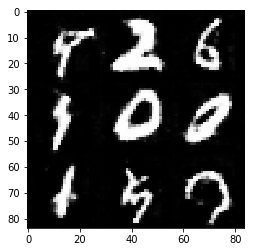

Epoch 2/2... Discriminator Loss: 1.5307... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.3312
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 2.4167
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.5635
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 0.9808
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.6718


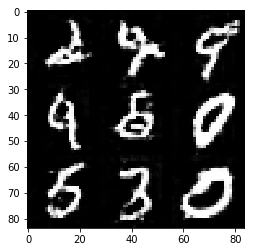

Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.5747
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.4164
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 1.9709
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.4032
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 2.3820
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 2.9061


IndexError: list index out of range

In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.2752
Epoch 1/1... Discriminator Loss: 6.6390... Generator Loss: 0.0040
Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 5.4783
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 3.0445... Generator Loss: 0.0656


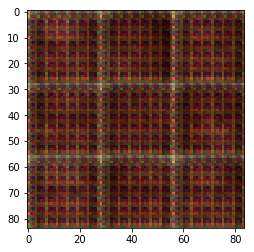

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 3.3850
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 2.8865
Epoch 1/1... Discriminator Loss: 2.2360... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.7857
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.3185


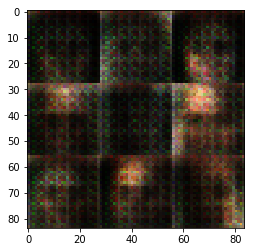

Epoch 1/1... Discriminator Loss: 2.3865... Generator Loss: 0.1601
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.6050
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.8242... Generator Loss: 0.2548
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9242


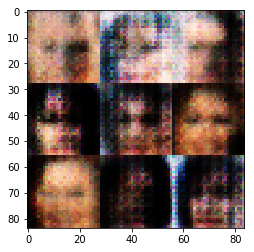

Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 2.0473... Generator Loss: 2.6656
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.9662
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.7801... Generator Loss: 0.3062
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5209


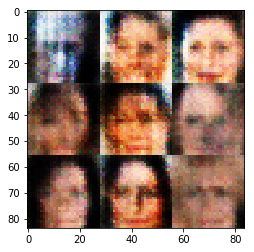

Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 2.8027
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 2.0804... Generator Loss: 0.1838
Epoch 1/1... Discriminator Loss: 1.9956... Generator Loss: 0.1922
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.2686
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.2823
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.6295


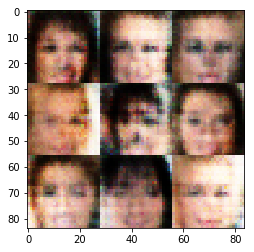

Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.9650... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.5959


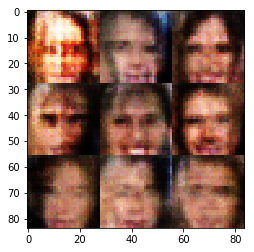

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.2281
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.9656


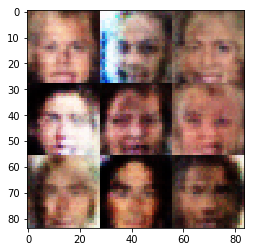

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.3778
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 1.4992
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.2977


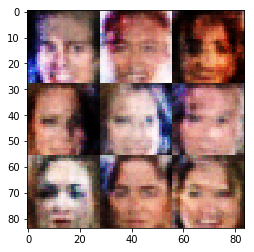

Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 1.8627
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.3288
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 2.2638
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4683


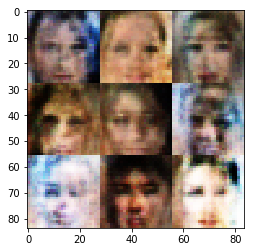

Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 2.1387
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.3094
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.3538


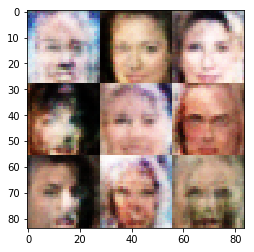

Epoch 1/1... Discriminator Loss: 1.8233... Generator Loss: 2.0645
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 2.2316
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.3764


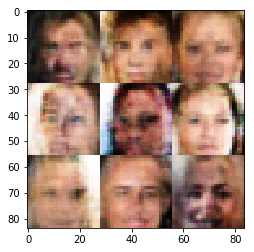

Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 2.3089
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.5182


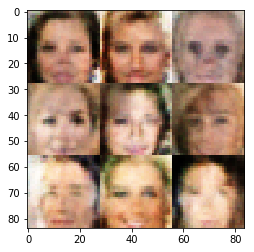

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.5744
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.2709
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.7469


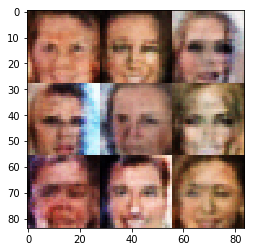

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.3375
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.6830
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0556


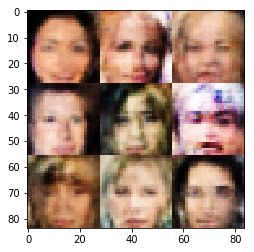

Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.3164
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.5545


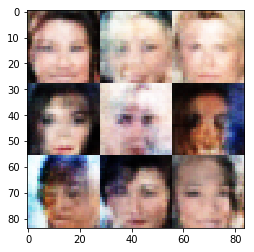

Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.2887
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.7980


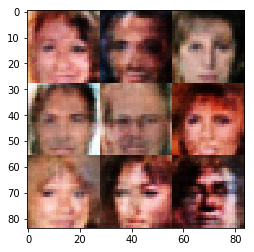

Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 2.2888
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.2928
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.4176


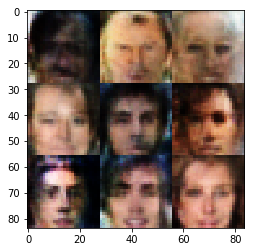

Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 1.9197... Generator Loss: 0.1928
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.5408


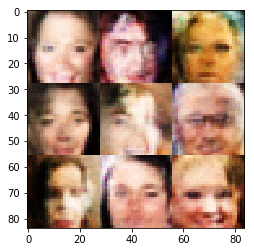

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.7619
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.3075
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 2.1756
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9633


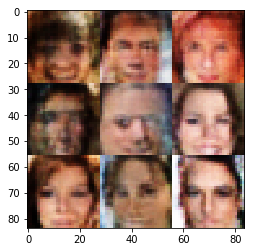

Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 2.0398... Generator Loss: 0.1889
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 1.6034
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6258


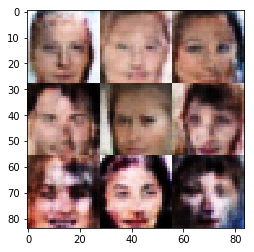

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6932


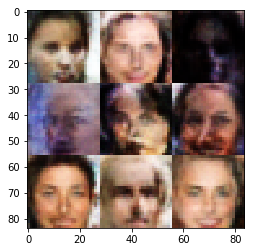

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.3031
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.3266
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.9608... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 1.8790


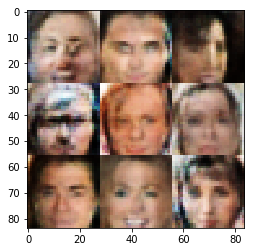

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.8923
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.3803


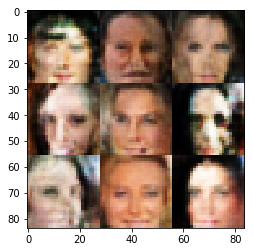

Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.8142... Generator Loss: 0.2434
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.2841
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.4896


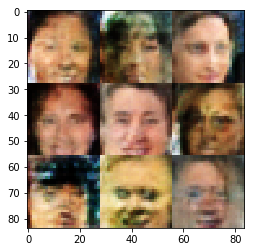

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 0.2436
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.8023... Generator Loss: 0.2754
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.8145


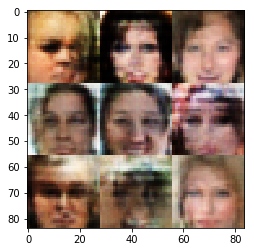

Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.0652


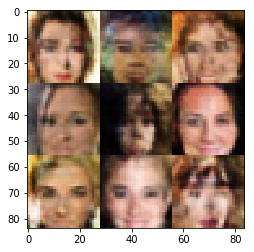

Epoch 1/1... Discriminator Loss: 1.7430... Generator Loss: 0.2468
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.2446
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.2755
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.3087
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 2.3645... Generator Loss: 0.1178


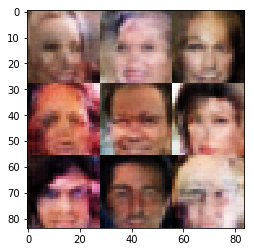

Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 2.3123
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 2.3118
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.8928... Generator Loss: 0.2338
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.2756
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.5132


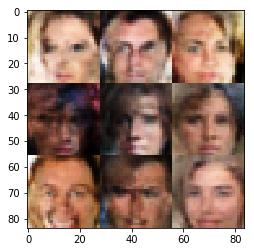

Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.8016... Generator Loss: 0.2389
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 3.0450
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 2.1812
Epoch 1/1... Discriminator Loss: 1.9072... Generator Loss: 0.2063


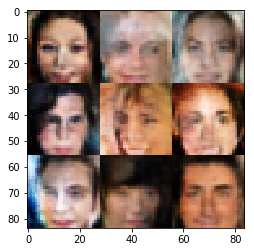

Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 3.8201
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 1.6538


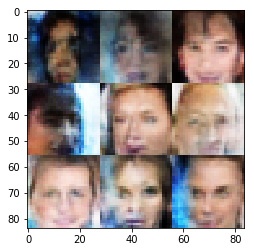

Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.7277... Generator Loss: 0.2464
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 1.6049
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 1.7352


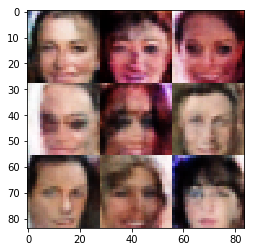

Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 3.5178
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 2.8992
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.9944
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.4099


IndexError: list index out of range

In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.